<a href="https://colab.research.google.com/github/jayliu1016/Xai_3/blob/main/notebooks/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following coding is using templates and coding-functions from my last yaer classes: IDS Machine learning and IDS Data engineering projects, and didn't use AI-generative tools except two places which I used gemni to auto-correct.(which I have aslo commented below)

In [24]:
!pip -q install PyALE statsmodels --upgrade


In [25]:
# Template from IDS PDS
import os, pandas as pd
CSV_LOCAL = "data/AmesHousing.csv"
REPO_RAW = "https://raw.githubusercontent.com/jayliu1016/Xai_3/main/data/AmesHousing.csv"

def load_ames():
    if os.path.exists(CSV_LOCAL):
        return pd.read_csv(CSV_LOCAL)
    return pd.read_csv(REPO_RAW)

df = load_ames()
df.shape, df.head()


((2930, 82),
    Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
 0      1  526301100           20        RL         141.0     31770   Pave   
 1      2  526350040           20        RH          80.0     11622   Pave   
 2      3  526351010           20        RL          81.0     14267   Pave   
 3      4  526353030           20        RL          93.0     11160   Pave   
 4      5  527105010           60        RL          74.0     13830   Pave   
 
   Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
 0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
 1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
 2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
 3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
 4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   
 
   Misc Val Mo Sold Yr Sold Sale Type  Sale Con

In [26]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
assert isinstance(df, pd.DataFrame) and len(df) > 0

aliases = {
    "SalePrice": ["SalePrice", "Sale_Price"],
    "GrLivArea": ["Gr Liv Area", "GrLivArea"],
    "GarageArea": ["Garage Area", "GarageArea"],
    "TotalBsmtSF": ["Total Bsmt SF", "TotalBsmtSF"],
    "1stFlrSF": ["1st Flr SF", "1stFlrSF"],
    "OverallQual": ["Overall Qual", "OverallQual"],
    "YearBuilt": ["Year Built", "YearBuilt"],
}

def resolve(name_key):
    for cand in aliases[name_key]:
        if cand in df.columns:
            return cand
    raise KeyError(f"Cannot find column for {name_key}. Present cols head: {df.columns[:10].tolist()}")

cols = {k: resolve(k) for k in aliases.keys()}
cols


{'SalePrice': 'SalePrice',
 'GrLivArea': 'Gr Liv Area',
 'GarageArea': 'Garage Area',
 'TotalBsmtSF': 'Total Bsmt SF',
 '1stFlrSF': '1st Flr SF',
 'OverallQual': 'Overall Qual',
 'YearBuilt': 'Year Built'}

## Data loading & schema preview
I load the Ames Housing CSV from GitHub raw (fallback to local).  
The table has 2,930 rows and 82 columns. A quick head shows typical variables: size, quality ratings, years, and price.

Assumption: "SalePrice" is the target. No transformation yet (I comment on skew later).


Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2216,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,220000
836,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,143000
2396,2397,528144030,60,RL,86.0,11065,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,281000
1962,1963,535452060,20,RL,70.0,7000,Pave,NaN,Reg,Lvl,...,0,NaN,MnWw,NaN,0,4,2007,WD,Family,135000
305,306,911202100,50,C (all),66.0,8712,Pave,Pave,Reg,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,102776


,0
Pool QC,0.995563
Misc Feature,0.963823
Alley,0.932423
Fence,0.804778
Mas Vnr Type,0.605802
Fireplace Qu,0.485324
Lot Frontage,0.167235
Garage Qual,0.054266
Garage Yr Blt,0.054266
Garage Cond,0.054266


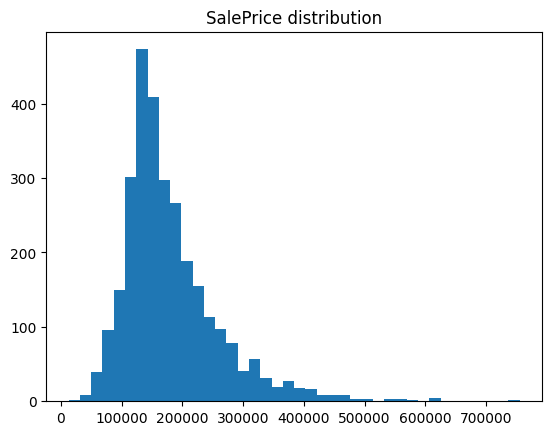

In [27]:
print("Shape:", df.shape)
display(df.sample(5, random_state=0))

missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].head(20))

tar_col = cols["SalePrice"]
plt.figure(); plt.hist(df[tar_col].dropna(), bins=40); plt.title("SalePrice distribution"); plt.show()


In [28]:
fea_cols = [cols[k] for k in ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "OverallQual", "YearBuilt"]]
use_cols = fea_cols + [tar_col]

df_model = df[use_cols].dropna().copy()
print(df_model.shape)
df_model.head()


(2928, 7)


,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Year Built,SalePrice
0,1656,528.0,1080.0,1656,6,1960,215000
1,896,730.0,882.0,896,5,1961,105000
2,1329,312.0,1329.0,1329,6,1958,172000
3,2110,522.0,2110.0,2110,7,1968,244000
4,1629,482.0,928.0,928,5,1997,189900


## Missingness & target distribution
- Several variables have non-trivial missingness (e.g., pool/garage/basement related).  
- The histogram of "SalePrice" is right-skewed with a long tail.  
- For modeling, log(price) could stabilize variance; however, I keep price in levels so PDP/ICE/ALE stay in original units. I will interpret changes relatively (trend/shape).
## Feature set for interpretability
I focus on six numeric features that are common and meaningful:
- "Gr Liv Area", "1st Flr SF", "Total Bsmt SF", "Garage Area" (size family)  
- "Overall Qual" (global quality score)  
- "Year Built" (vintage)


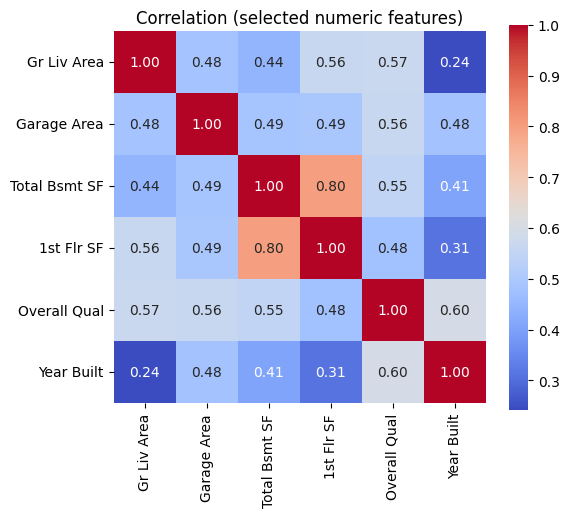

,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,Overall Qual,Year Built
Gr Liv Area,1.000000,0.484711,0.444819,0.562265,0.570576,0.241949
Garage Area,0.484711,1.000000,0.485504,0.491122,0.563337,0.479998
Total Bsmt SF,0.444819,0.485504,1.000000,0.800706,0.547252,0.407479
1st Flr SF,0.562265,0.491122,0.800706,1.000000,0.477640,0.310180
Overall Qual,0.570576,0.563337,0.547252,0.477640,1.000000,0.596796
Year Built,0.241949,0.479998,0.407479,0.310180,0.596796,1.000000


In [29]:
corr = df_model[fea_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation (selected numeric features)")
plt.show()
corr


## Correlation heatmap (EDA)
Main patterns:
- **1st Flr SF ↔ Total Bsmt SF ≈ 0.80** (very high).  
- "Gr Liv Area" has moderate correlation with "1st Flr SF" (≈ 0.56) and "Total Bsmt SF" (≈ 0.44).  
- "Overall Qual" correlates with size and year (≈ 0.48–0.60).  
- "Garage Area" correlates with "Year Built" (≈ 0.48).

The size features form a correlated cluster. This matters because standard PDP averages over **unrealistic combinations** in correlated regions; ALE is more robust there.


In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(df_model[fea_cols])
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_df = vif_df.query("feature != 'const'").sort_values("VIF", ascending=False)
vif_df


,feature,VIF
4,1st Flr SF,3.353463
3,Total Bsmt SF,3.222132
5,Overall Qual,2.466620
1,Gr Liv Area,1.930599
2,Garage Area,1.756901
6,Year Built,1.727657


## VIF (multicollinearity)
VIF on selected features:
- “1st Flr SF” ≈ **3.35**, “Total Bsmt SF” ≈ **3.22** (noticeable collinearity).
- “Overall Qual” ≈ 2.49; “Gr Liv Area” ≈ 1.93; “Garage Area” ≈ 1.76; “Year Built” ≈ 1.73.


It shows moderate multicollinearity, mainly within the size family. I will be cautious when interpreting size effects with PDP and compare with ALE.


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df_model[fea_cols]
y = df_model[tar_col]

# used Gemini to auto correct my selection for the next following coding at 12 a.m. Sep 28th
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, pred, )
r2 = r2_score(y_test, pred)
print({"RMSE": rmse, "R2": r2})

{'RMSE': 797310600.9517791, 'R2': 0.9030178013225764}


In [32]:
import numpy as np
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print({"MSE": mse, "RMSE": rmse, "R2": r2})


{'MSE': 797310600.9517791, 'RMSE': np.float64(28236.68891622704), 'R2': 0.9030178013225764}


## Model performance
Random Forest (80/20 split): R² ≈ 0.90, RMSE ≈ 28k.  
This accuracy is sufficient for effect plots. Nonlinearity is captured without strong modeling assumptions.


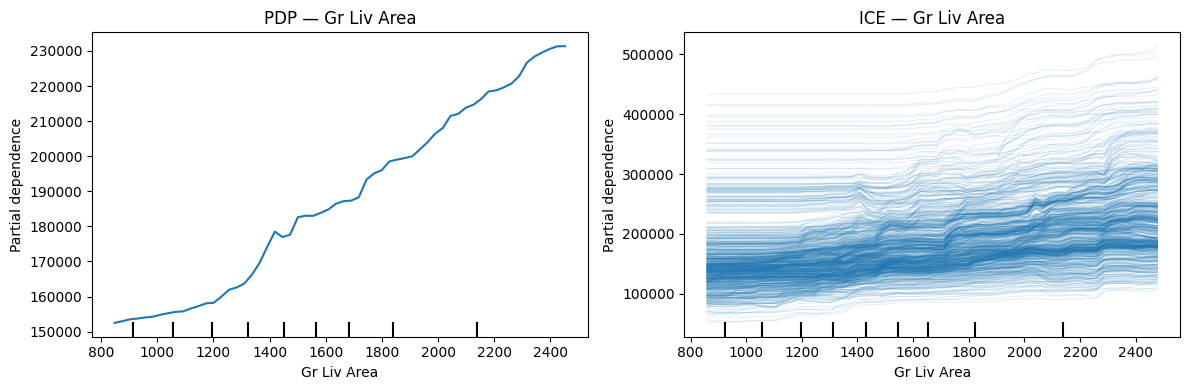

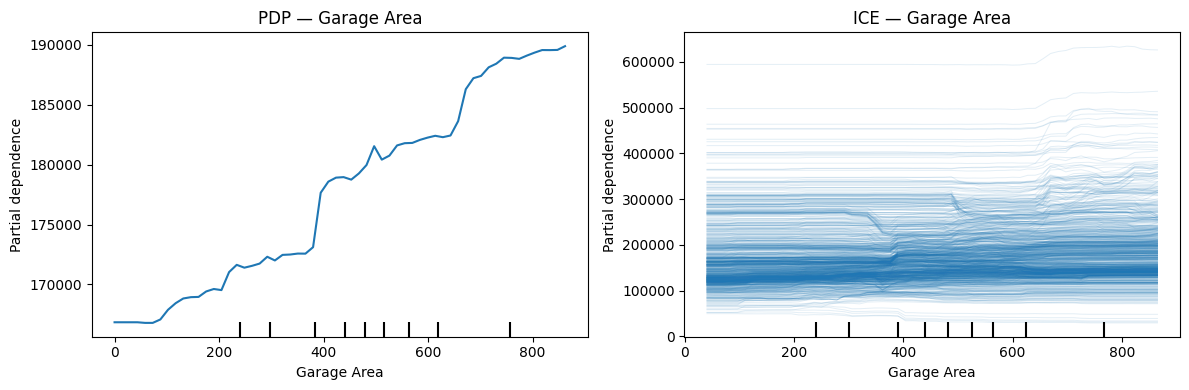

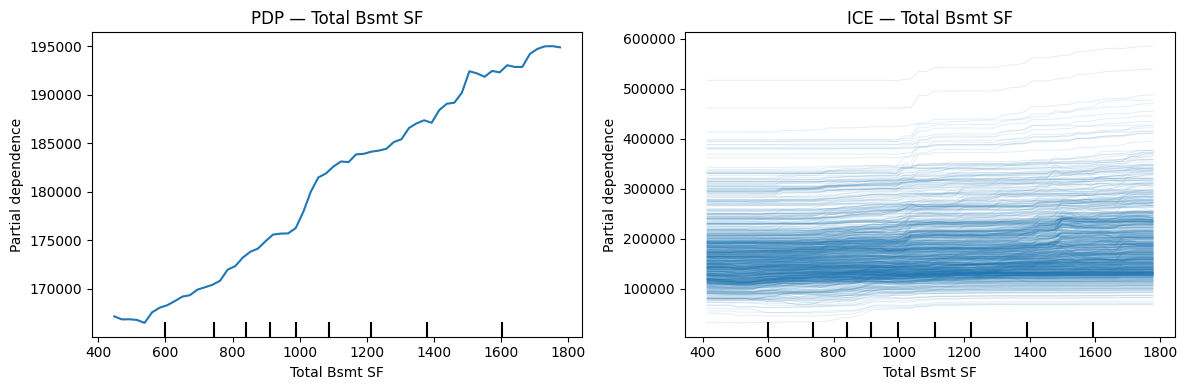

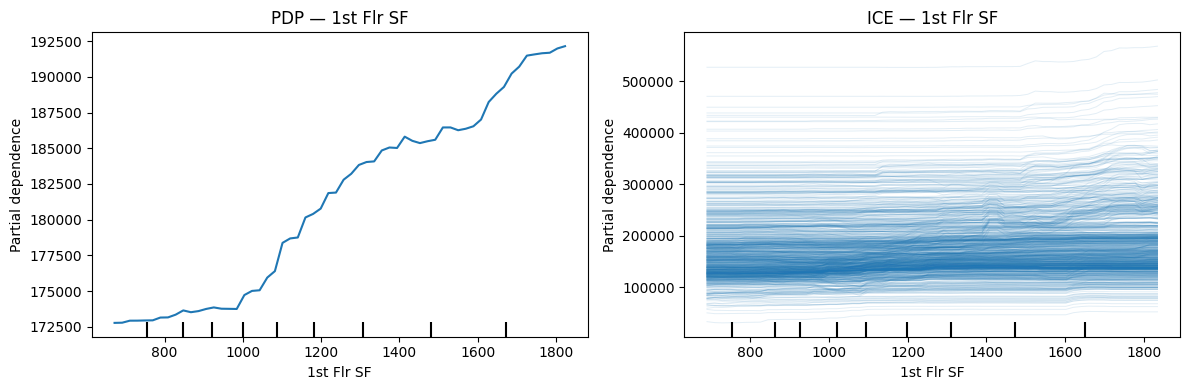

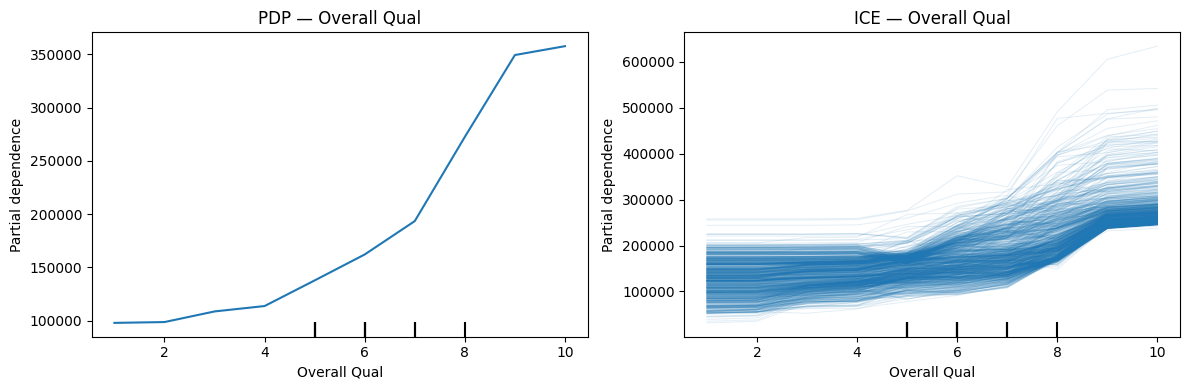

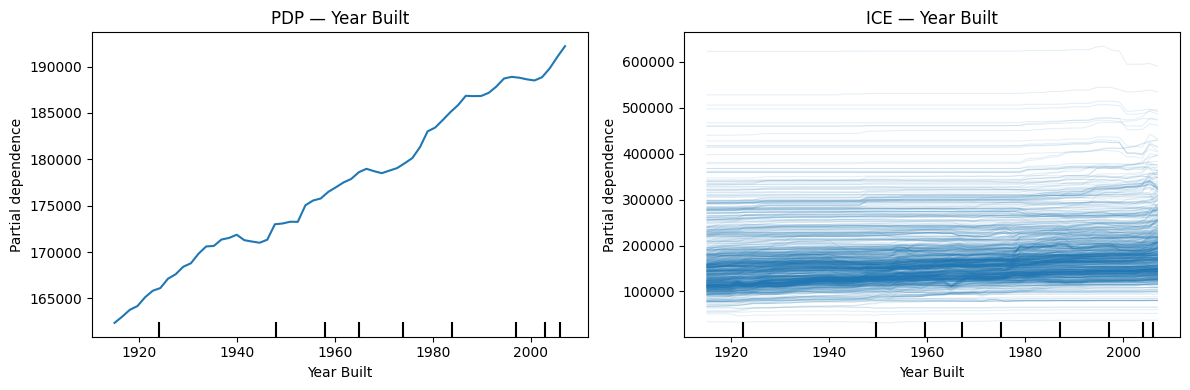

In [33]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

f_t_p = [c for c in fea_cols if c in X_train.columns]

n_ice = min(800, len(X_train))
X_ice = X_train.sample(n_ice, random_state=42)

for ftr in f_t_p:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    PartialDependenceDisplay.from_estimator(
        rf, X_train, [ftr],
        kind="average", grid_resolution=60, ax=ax[0]
    )
    ax[0].set_title(f"PDP — {ftr}")

    PartialDependenceDisplay.from_estimator(
        rf, X_ice, [ftr],
        kind="individual",
        grid_resolution=60,
        ice_lines_kw={"alpha": 0.12, "linewidth": 0.7},
        ax=ax[1]
    )
    ax[1].set_title(f"ICE — {ftr}")
    plt.tight_layout()
    plt.show()


## PDP & ICE (used GPT-5 for format and grammar paraphrase)
PDP gives the *average* marginal trend; ICE shows individual curves and heterogeneity. With correlated features, PDP may look steeper at tails; ICE reveals spread and interactions.

- **Gr Liv Area**  
  - PDP: strong monotone increase; mild flattening at very large area.  
  - ICE: clear fan-shape; bigger gains for some homes, which means likely higher quality/newer.  
- **1st Flr SF**  
  - PDP: fast rise around ~1.1–1.6k sqft, then gentler.  
  - ICE: heterogeneous slopes; several subgroups with different sensitivities.  
- **Total Bsmt SF**  
  - PDP: positive with saturation near the top end.  
  - ICE: dispersion increases for large basements.  
- **Garage Area**  
  - PDP: mild–moderate gains, small plateaus mid-range.  
  - ICE: smaller spread than living area; effect present but secondary.  
- **Overall Qual**  
  - PDP: step-like growth; large jump at levels 8–10.  
  - ICE: curves mostly parallel and the effect consistent across units.  
- **Year Built**  
  - PDP: smooth upward trend; small mid-century plateau.  
  - ICE: noticeable spread interaction with size/quality, which indicates that newer homes often larger, higher quality.

**Interpretation:** Size and quality dominate; ICE highlights strong heterogeneity for size variables and more uniform shifts for quality.


INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.
INFO:PyALE._ALE_generic:Discrete feature detected.
INFO:PyALE._ALE_generic:Continuous feature detected.


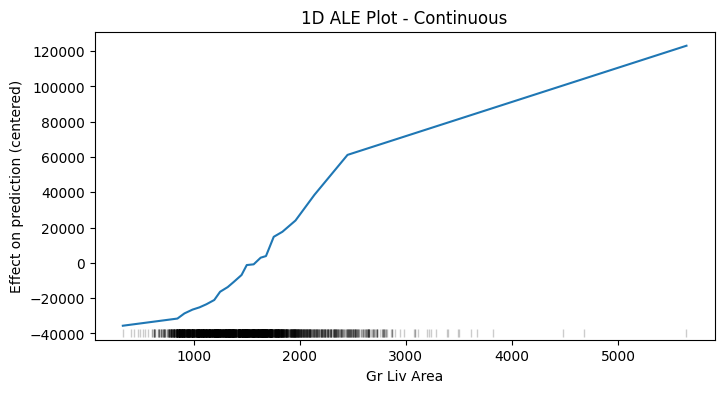

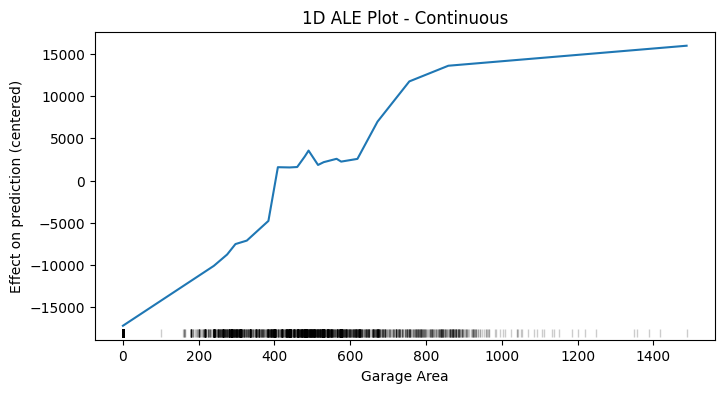

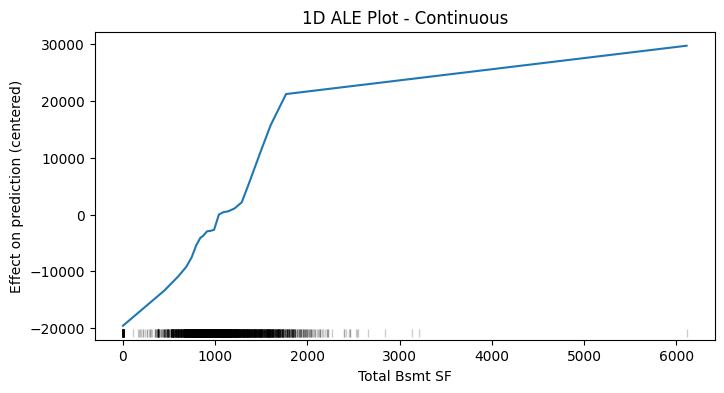

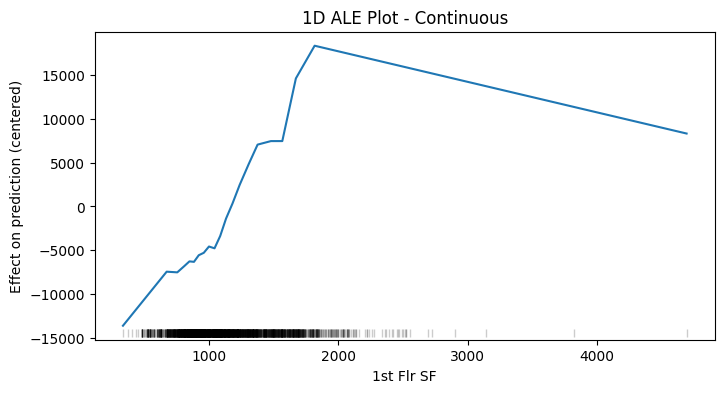

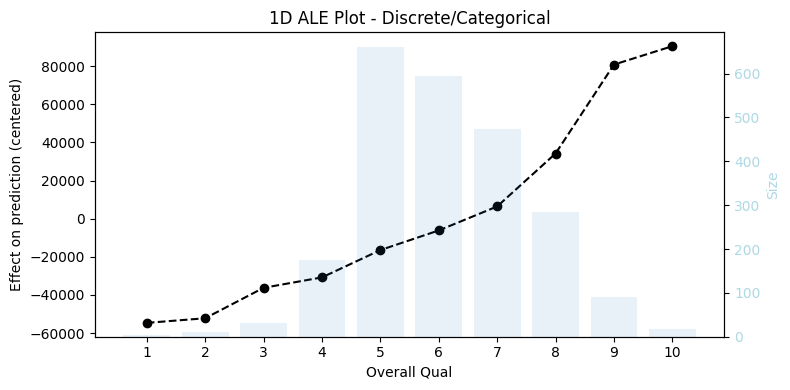

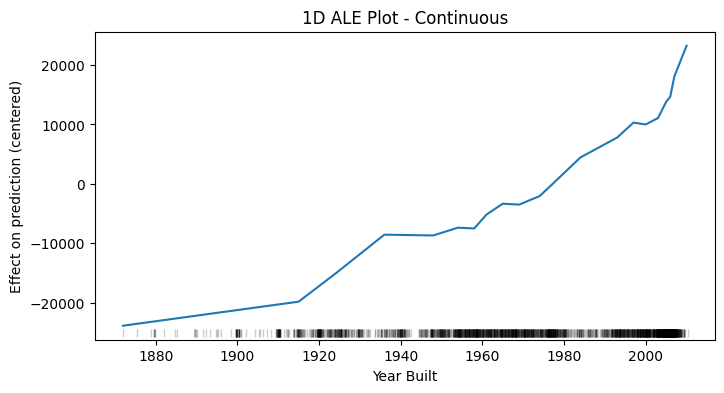

In [34]:
from PyALE import ale
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=fea_cols)

# used Gemini to correct my coding; before it was mannual selection, now it used auto-default mode.(1:30 a.m. on Sep 28th)
def plot_ale_1d(model, X, feature, bins=20):
    _ = ale(
        X=X,
        model=model,
        feature=[feature],
        grid_size=bins,
        include_CI=False,
        plot=True
    )

for ftr in f_t_p:
    plot_ale_1d(rf, X_train, ftr, bins=20)


## ALE (used GPT for format only)

ALE uses local differences within observed bins; curves align with data density and are more conservative in sparse regions.

- **Gr Liv Area**: monotone increase; flatter than PDP at extremes.  
- **1st Flr SF**: rise up to ~1.7–1.9k sqft, then slight decline/flattening.  
- **Total Bsmt SF**: strong positive up to ~1.5–1.8k sqft, then saturation.  
- **Garage Area**: small positive effect; smoother than PDP for very large garages.  
- **Overall Qual**: huge step and largest jump at high quality.  
- **Year Built**: gradual increase; stable in early years, acceleration after 1980.

**Interpretation.** For the correlated size cluster, ALE provides the more reliable marginal shapes; conclusions for quality and vintage are consistent with PDP/ICE.


## PDP vs ICE vs ALE — summary, correlation impact, and limitations (used GPT for formatting)

**PDP (global average).** Captures overall nonlinear trends such as diminishing returns for size. In my results: living-area variables rise with mild flattening at high values; quality shows step-like gains. It also has **Limitation** with correlated predictors, PDP averages over unrealistic combinations, so tails can look too steep.

**ICE (individual curves).** Reveals heterogeneity and interactions hidden by PDP. I saw fan-shaped spreads for size features, some homes benefit more from extra area, while "Overall Qual" curves are mostly parallel. I will use ICE to diagnose subgroup behavior and stability behind PDP.

**ALE (local effects).** Integrates local differences within observed bins; respects data density. For the correlated size cluster, ALE is **more conservative** than PDP because flatter in sparse extremes, showing saturation like "basement" and flattening for "1st Flr SF". I prefer ALE when features are correlated.

**Impact of correlation.** EDA shows a size cluster: "1st Flr SF"  "Total Bsmt SF" ≈ **0.80**; they both relate to "Gr Liv Area". VIF ≈ **3** for the strongest pair. Consequences:
- PDP may **overstate** marginal gains at extremes by averaging over unlikely mixes, let's say large basement + small first floor.
- ICE spreads widen at large sizes, suggesting interaction with quality.
- ALE reduces bias by conditioning on local neighborhoods; shapes are smoother.  

For size features, report effects primarily via **ALE**, treating PDP/ICE as supporting views; for "Overall Qual"/"Year Built", all three broadly agree.

In conclusion, I will sse **PDP+ICE** to understand global shape and heterogeneity; rely on **ALE** for the marginal shapes that we trust under correlation. Size and quality dominate, but marginal value of space declines and depends on correlated attributes (quality, vintage).


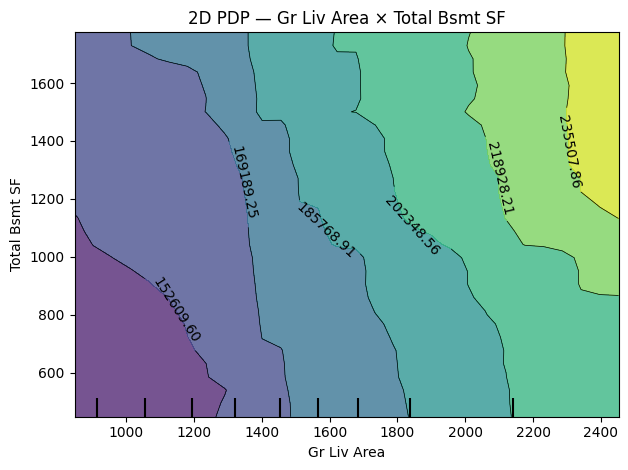

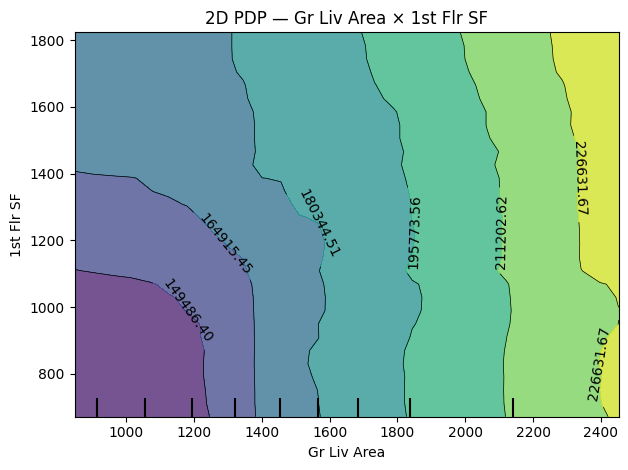

In [35]:
pairs = []
if all(c in X_train.columns for c in [fea_cols[0], fea_cols[2]]):
    pairs.append((fea_cols[0], fea_cols[2]))
if all(c in X_train.columns for c in [fea_cols[0], fea_cols[3]]):
    pairs.append((fea_cols[0], fea_cols[3]))

for p in pairs:
    disp = PartialDependenceDisplay.from_estimator(
        rf, X_train, [p], kind="average", grid_resolution=30
    )
    disp.axes_[0, 0].set_title(f"2D PDP — {p[0]} × {p[1]}")
    plt.tight_layout()
    plt.show()


## 2D PDP — Gr Liv Area × (Total Bsmt SF / 1st Flr SF)

This is a fun plot I picked up when I was doing my last year's project. I can twll contours are mostly vertical, meaning "Gr Liv Area" drives price more strongly than the other axis. Moving right (larger living area) increases prediction faster than moving up (larger basement/first floor). Isolines are tighter around 1,200–1,600 sqft and strongest sensitivity there; spacing widens beyond 2,200 sqft then shows diminishing return.

### Gr Liv Area × Total Bsmt SF
- Basement space adds value, but the gradient along the basement axis is smaller than along living area.  
- Curvature suggests mild complementarity: the gain from more living area is slightly larger when basement is medium–high, around 900–1,400 sqft, then it saturates.  
- Upper-left or lower-right corners (huge basement with small living area, or vice versa) look optimistic, these mixes are rare; PDP may over-average there.

### Gr Liv Area × 1st Flr SF
- Contours are close to **parallel bands**: effect appears more additive; both features move price in the same direction with no strong interaction.  
- Still, living area dominates the slope; first-floor gains are smaller and flatten when "Gr Liv Area' is already high.  
- Because "Gr Liv Area" and "1st Flr SF" are correlated, extreme corners may be unrealistic.

Three suggestions:
1) Expanding total living area yields the largest payoff; basement/first-floor expansion helps but with saturation.  
2) Interaction strength is modest (complementarity is limited); most of the surface looks near-additive.  
3) Tails are data-sparse; treat edge contours as low confidence (PDP limitation under correlation).
